# 🤖 Análise de Consenso entre LLMs
## Notebook Refatorado com Alternative Params

Este notebook usa:
- Componentes modulares
- Logging com loguru
- Integração com HuggingFace
- **Alternative params** para testar variações

## 1️⃣ Setup e Configuração

In [1]:
# Imports
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from loguru import logger
import pandas as pd

# Configurar logging
logger.remove()
logger.add(
    sys.stdout,
    format="<green>{time:HH:mm:ss}</green> | <level>{level: <8}</level> | <level>{message}</level>",
    level="INFO"
)

logger.success("✓ Setup completo")

22:01:27 | SUCCESS  | ✓ Setup completo


## 2️⃣ Carregar Dataset do HuggingFace

In [2]:
from src.utils.data_loader import load_hf_dataset, load_hf_dataset_as_dataframe, list_available_datasets

# Listar datasets
logger.info("Datasets disponíveis:")
for dataset in list_available_datasets():
    logger.info(f"  - {dataset}")

22:01:28 | Datasets disponíveis:
22:01:28 |   - agnews
22:01:28 |   - mpqa
22:01:28 |   - webkb
22:01:28 |   - ohsumed
22:01:28 |   - acm
22:01:28 |   - yelp_2013
22:01:28 |   - dblp
22:01:28 |   - books
22:01:28 |   - reut90
22:01:28 |   - wos11967
22:01:28 |   - twitter
22:01:28 |   - trec
22:01:28 |   - wos5736
22:01:28 |   - sst1
22:01:28 |   - pang_movie
22:01:28 |   - movie_review
22:01:28 |   - vader_movie
22:01:28 |   - subj
22:01:28 |   - sst2
22:01:28 |   - yelp_reviews
22:01:28 |   - 20ng
22:01:28 |   - medline


In [3]:
# Carregar dataset
dataset_name = "agnews"  # Ajuste conforme necessário

texts, categories, ground_truth = load_hf_dataset(dataset_name)

logger.info(f"Textos: {len(texts)}")
logger.info(f"Categorias: {categories}")
logger.info(f"Ground truth: {'Sim' if ground_truth else 'Não'}")

22:01:28 | Carregando dataset: agnews
22:01:28 | Combinando splits: ['train', 'test']
22:01:34 |   ✓ train: 510400 exemplos
22:01:39 |   ✓ test: 127600 exemplos
22:01:39 | Total combinado: 638000 exemplos
22:01:39 | Categorias extraídas automaticamente: [0, 1, 2, 3]
22:01:40 | Coluna de texto: text
22:01:40 | Ground truth carregado da coluna 'label'
22:01:40 | Textos: 638000
22:01:40 | Categorias: [0, 1, 2, 3]
22:01:40 | Ground truth: Sim


In [4]:
# Visualizar amostra
logger.info("Amostra dos textos:")
for i, text in enumerate(texts[:3]):
    logger.info(f"{i+1}. {text[:100]}...")
    if ground_truth:
        logger.info(f"   Label: {ground_truth[i]}")

22:01:40 | Amostra dos textos:
22:01:40 | 1. "Irish Claim 2nd Title","Notre Dame goalkeeper Erika Bohn seals the Irish's second NCAA championship...
22:01:40 |    Label: 1
22:01:40 | 2. "Court rules for BC in flap over exit fee","Boston College cleared a major legal hurdle in its bid t...
22:01:40 |    Label: 1
22:01:40 | 3. "Scientific Method Man","Gordon Rugg cracked the 400-year-old mystery of the Voynich manuscript. Nex...
22:01:40 |    Label: 3


In [5]:
df, categories = load_hf_dataset_as_dataframe(dataset_name)

22:01:40 | Carregando dataset: agnews
22:01:40 | Combinando splits: ['train', 'test']
22:01:45 |   ✓ train: 510400 exemplos
22:01:51 |   ✓ test: 127600 exemplos
22:01:51 | Total combinado: 638000 exemplos
22:01:51 | Categorias extraídas automaticamente: [0, 1, 2, 3]
22:01:52 | Coluna de texto: text
22:01:52 | Ground truth carregado da coluna 'label'
22:01:52 | DataFrame criado com 638000 linhas


In [6]:
categories

[0, 1, 2, 3]

## 3️⃣ Configurar Modelos LLM

### Opção B: Usar alternative params (temp=0, 0.3, 0.5)

**Atenção**: Isso cria 9 modelos (3 base + 6 variações)

In [7]:
from src.llm_annotation_system.annotation.llm_annotator import LLMAnnotator
from src.experiments.base_experiment import DEFAULT_MODELS, BASE_ANNOTATION_PROMPT

annotator = LLMAnnotator(
    dataset_name=dataset_name,
    categories=categories,
    models=DEFAULT_MODELS,
    prompt_template=BASE_ANNOTATION_PROMPT,
    use_langchain_cache=True,
    use_alternative_params=True
)

logger.success(f"✓ Annotator com alternative params: {len(annotator.models)} modelos")
logger.info(f"  Modelos expandidos: {annotator.models}")

22:01:53 | Cache carregado: 220 entradas
22:01:53 | Cache LangChain ativado: ..\..\data\.cache\langchain\langchain_cache.db
22:01:53 | Template do prompt preparado
22:01:53 | Alternative params ativado: 15 variações
22:01:53 | LLMAnnotator inicializado
22:01:53 | Modelos: 15 | Categorias: 4
22:01:53 | ✓ Annotator com alternative params: 15 modelos
22:01:53 |   Modelos expandidos: ['deepseek-r1-8b', 'deepseek-r1-8b_alt1', 'deepseek-r1-8b_alt2', 'qwen3-8b', 'qwen3-8b_alt1', 'qwen3-8b_alt2', 'gemma3-4b', 'gemma3-4b_alt1', 'gemma3-4b_alt2', 'mistral-7b', 'mistral-7b_alt1', 'mistral-7b_alt2', 'llama3.1-8b', 'llama3.1-8b_alt1', 'llama3.1-8b_alt2']


## 4️⃣ Executar Anotação

### Testar anotação

In [8]:
# Parâmetros
num_repetitions = 3
text = texts[0]
model = "llama3.1-8b"

# Estimativa
total_annotation = len(text) * num_repetitions
logger.warning(f"  Modelo: {model}")
logger.warning(f"  Texto: {len(text)}")
logger.warning(f"  Repetições: {num_repetitions}")

# Anotar
annotations = annotator.annotate_single(
    text=text,
    model=model,
    num_repetitions=num_repetitions,
    use_cache=False
)

logger.success("✓ Anotação completa")

annotations

22:01:53 |   Modelo: llama3.1-8b
22:01:53 |   Texto: 191
22:01:53 |   Repetições: 3
22:01:54 | ✓ Anotação completa


[1, 1, 1]

### Anotando dataset completo

In [9]:
output_file = annotator.results_dir / "annotations_complete.csv"

if output_file.exists():
    logger.warning(f"Arquivo já existe: {output_file}")
    logger.warning("Carregando anotações salvas e pulando anotação...")
    df_annotations = pd.read_csv(output_file)
    logger.success("✓ Anotações carregadas do disco")
    
else: 
    num_repetitions = 1
    df_annotations = annotator.annotate_dataset(
        texts=texts,
        num_repetitions=num_repetitions,
        use_cache=False
    )

logger.success("✓ Anotações completas")
display(df_annotations.head())

22:01:54 | Arquivo já existe: ..\..\results\agnews\annotations_complete.csv
22:01:54 | Carregando anotações salvas e pulando anotação...
22:01:54 | ✓ Anotações carregadas do disco
22:01:54 | ✓ Anotações completas


,text_id,text,deepseek-r1-8b_rep1,deepseek-r1-8b_consensus,deepseek-r1-8b_consensus_score,qwen3-8b_rep1,qwen3-8b_consensus,qwen3-8b_consensus_score,gemma3-4b_rep1,gemma3-4b_consensus,gemma3-4b_consensus_score,mistral-7b_rep1,mistral-7b_consensus,mistral-7b_consensus_score,llama3.1-8b_rep1,llama3.1-8b_consensus,llama3.1-8b_consensus_score
0,0,"""Irish Claim 2nd Title"",""Notre Dame goalkeeper...",1,1,1.0,1,1,1.0,1,1,1.0,3,3,1.0,1,1,1.0
1,1,"""Court rules for BC in flap over exit fee"",""Bo...",1,1,1.0,1,1,1.0,1,1,1.0,2,2,1.0,0,0,1.0
2,2,"""Scientific Method Man"",""Gordon Rugg cracked t...",3,3,1.0,3,3,1.0,3,3,1.0,3,3,1.0,3,3,1.0
3,3,"""Money From Salvadoran Immigrants Aids Farming...",2,2,1.0,2,2,1.0,2,2,1.0,3,3,1.0,2,2,1.0
4,4,"""U.S. Pounds Falluja Diehards, Violence in Nor...",0,0,1.0,0,0,1.0,2,2,1.0,2,2,1.0,0,0,1.0


### - Metricas por modelo

In [10]:
df_annotations["ground_truth"] = ground_truth if ground_truth else None
df_metrics = annotator.evaluate_model_metrics(
    df_annotations, 
    ground_truth_col="ground_truth", 
    output_csv=True
)

ValueError: Length of values (638000) does not match length of index (100)

## 5️⃣ Calcular Consenso

In [ ]:
from src.llm_annotation_system.consensus.consensus_calculator import ConsensusCalculator
from src.llm_annotation_system.consensus.consensus_evaluator import ConsensusEvaluator
from src.experiments.base_experiment import EXPERIMENT_CONFIG

# Inicializar calculador
calculator = ConsensusCalculator(
    consensus_threshold=EXPERIMENT_CONFIG['consensus'].get('threshold', 0.8),
    default_strategy=EXPERIMENT_CONFIG['consensus'].get('strategy', "majority_vote")
)

analyzer = ConsensusEvaluator(categories=categories, calculator=calculator)
df_with_consensus = analyzer.compute_consensus(df_annotations)

# Estatísticas
logger.info("\n📊 Estatísticas de Consenso:")
logger.info(f"  Média: {df_with_consensus['consensus_score'].mean():.2%}")
logger.info(f"  Mediana: {df_with_consensus['consensus_score'].median():.2%}")
logger.info(f"  Desvio padrão: {df_with_consensus['consensus_score'].std():.2%}")

# Distribuição por nível
levels = df_with_consensus['consensus_level'].value_counts()
logger.info("\nDistribuição por nível:")
for level, count in levels.items():
    logger.info(f"  {level}: {count} ({count/len(df_with_consensus):.1%})")

20:44:54 | INFO     | Executando cálculo de consenso interno...
20:44:54 | INFO     | Calculando consenso...


KeyError: 'flag_for_review'

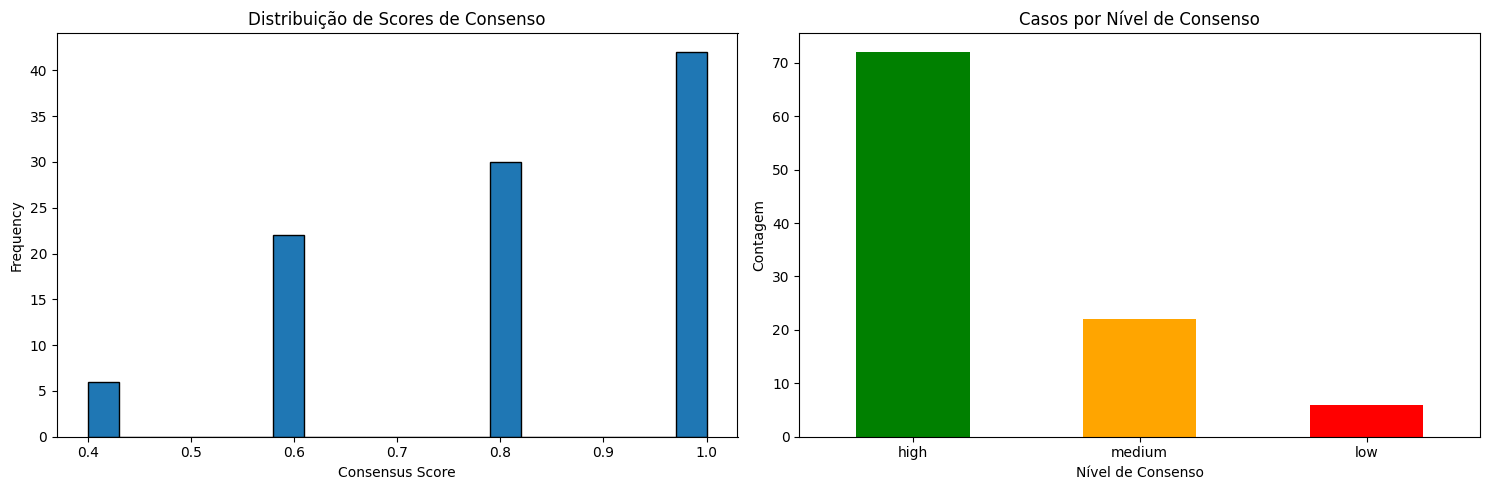

In [ ]:
# Visualizações
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(df_with_consensus['consensus_score'], bins=20, edgecolor='black')
axes[0].set_xlabel('Consensus Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribuição de Scores de Consenso')

# Barras por nível
levels.plot(kind='bar', ax=axes[1], color=['green', 'orange', 'red'])
axes[1].set_xlabel('Nível de Consenso')
axes[1].set_ylabel('Contagem')
axes[1].set_title('Casos por Nível de Consenso')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 6️⃣ Análise de Alternative Params

**Nota**: Esta seção só funciona se `use_alternative_params=True`

In [ ]:
# Verificar se alternative params foi usado
if annotator.use_alternative_params:
    logger.info("📊 Analisando impacto dos alternative params...")
    
    # Agrupar por modelo base
    for base_model in models:
        # Encontrar variações deste modelo
        variations = [m for m in annotator.models if m.startswith(base_model)]
        
        logger.info(f"\n{base_model}:")
        
        for var in variations:
            if f'{var}_consensus_score' in df_with_consensus.columns:
                score = df_with_consensus[f'{var}_consensus_score'].mean()
                logger.info(f"  {var}: {score:.2%} consenso interno")
    
    # Comparar temperaturas
    fig, ax = plt.subplots(figsize=(12, 6))
    
    consensus_cols = [col for col in df_with_consensus.columns 
                     if '_consensus_score' in col and '_alt' in col or 
                     (col.replace('_consensus_score', '') in models)]
    
    if consensus_cols:
        means = [df_with_consensus[col].mean() for col in consensus_cols]
        labels = [col.replace('_consensus_score', '') for col in consensus_cols]
        
        ax.bar(labels, means)
        ax.set_ylabel('Consenso Interno Médio')
        ax.set_title('Consenso por Variação de Parâmetros')
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()
    
else:
    logger.warning("Alternative params não foi usado. Para análise detalhada, reinicialize com use_alternative_params=True")

16:34:42 | WARNING  | Alternative params não foi usado. Para análise detalhada, reinicialize com use_alternative_params=True


## 7️⃣ Análise Detalhada de Consenso

In [ ]:
# Colunas de consenso
consensus_cols = [col for col in df_with_consensus.columns if '_consensus' in col and '_score' not in col]

logger.info(f"Analisando {len(consensus_cols)} anotadores")

# Gerar relatório
report = analyzer.generate_consensus_report(
    df=df_with_consensus,
    annotator_cols=consensus_cols,
    output_dir="./results"
)

logger.success("✓ Relatório gerado")

16:36:22 | INFO     | Analisando 5 anotadores
16:36:22 | INFO     | Gerando relatório de consenso...
16:36:22 | WARNING  | Erro ao calcular Cohen's Kappa: Classification metrics can't handle a mix of multiclass and unknown targets
16:36:22 | WARNING  | Erro ao calcular Cohen's Kappa: Classification metrics can't handle a mix of multiclass and unknown targets
16:36:22 | WARNING  | Erro ao calcular Cohen's Kappa: Classification metrics can't handle a mix of unknown and multiclass targets
16:36:22 | WARNING  | Erro ao calcular Cohen's Kappa: unknown is not supported
16:36:22 | WARNING  | Erro ao calcular Cohen's Kappa: Classification metrics can't handle a mix of unknown and multiclass targets
16:36:22 | WARNING  | Erro ao calcular Cohen's Kappa: Classification metrics can't handle a mix of multiclass and unknown targets
16:36:22 | WARNING  | Erro ao calcular Cohen's Kappa: Classification metrics can't handle a mix of unknown and multiclass targets
16:36:22 | INFO     | Fleiss' Kappa: 0.5

In [ ]:
# Métricas
logger.info("\n📊 Métricas de Concordância:")
logger.info(f"  Fleiss' Kappa: {report['fleiss_kappa']:.3f} ({report['fleiss_interpretation']})")

# Interpretação
kappa = report['fleiss_kappa']
if kappa > 0.8:
    logger.success("Concordância excelente!")
elif kappa > 0.6:
    logger.info("Concordância boa")
elif kappa > 0.4:
    logger.warning("Concordância moderada")
else:
    logger.warning("Concordância fraca")

16:34:42 | INFO     | 
📊 Métricas de Concordância:
16:34:42 | INFO     |   Fleiss' Kappa: 0.569 (Moderado)
16:34:42 | WARNING  | Concordância moderada


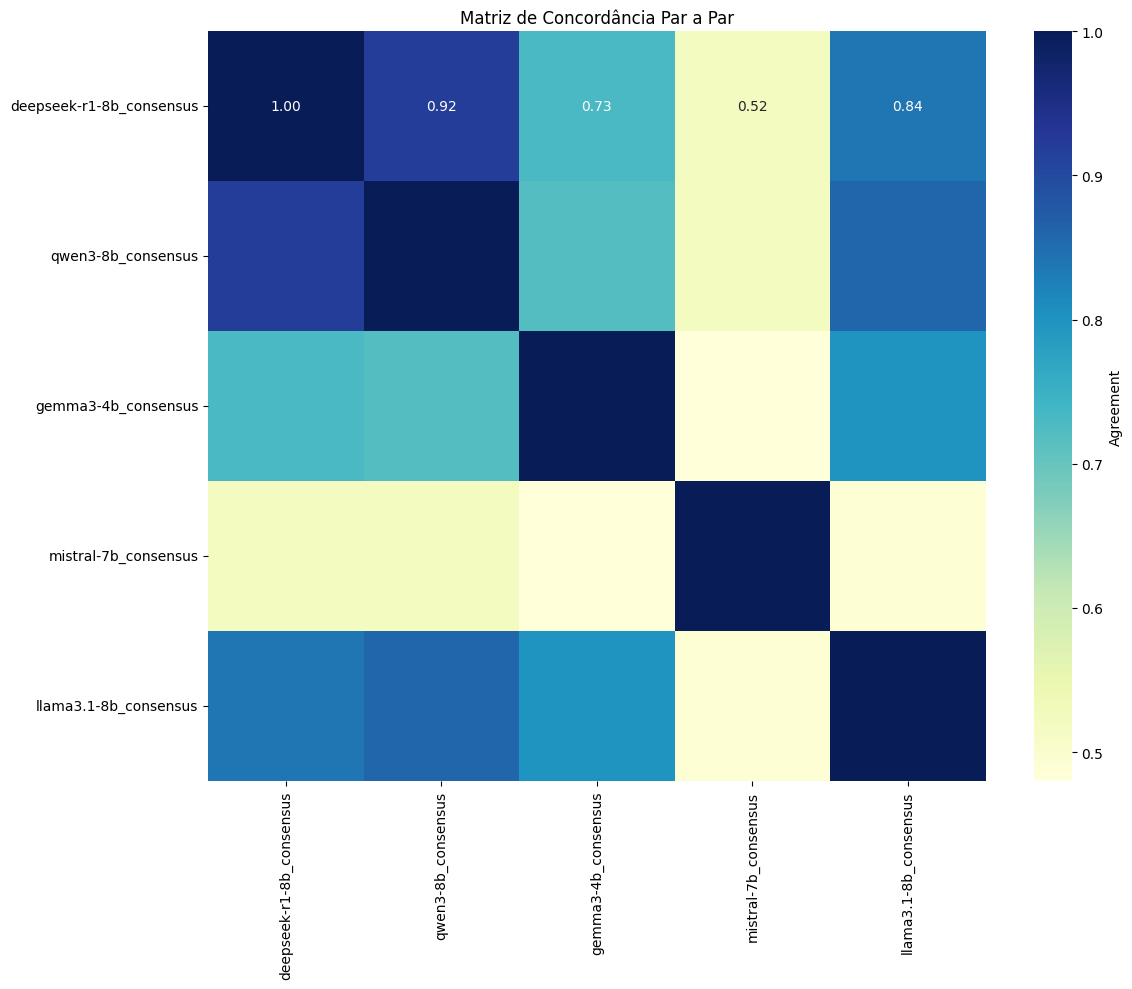

In [ ]:
# Matriz de concordância
agreement_df = report['pairwise_agreement']

plt.figure(figsize=(12, 10))
sns.heatmap(agreement_df, annot=True, fmt='.2f', cmap='YlGnBu', cbar_kws={'label': 'Agreement'})
plt.title('Matriz de Concordância Par a Par')
plt.tight_layout()
plt.show()

In [ ]:
# Casos problemáticos
problematic = report.get('problematic_cases')
if problematic is not None and len(problematic) > 0:
    logger.warning(f"\n⚠️  {len(problematic)} casos problemáticos identificados")
    display(problematic.head())
else:
    logger.success("\n✓ Nenhum caso problemático identificado")

16:34:43 | WARNING  | 
⚠️  6 casos problemáticos identificados


,text_id,text,consensus_score,annotations,entropy
0,24,"""Plenty of Flaws Among the Facts"",""President B...",0.4,"{0: 2, 2: 2, 3: 1}",1.521928
1,41,"""Bush, Kerry Duel Over Health Care Plans (AP)""...",0.4,"{0: 2, 2: 2, 3: 1}",1.521928
2,57,"""SF #39;bringing bug device to talks #39;"",""S...",0.4,"{0: 2, 2: 2, 3: 1}",1.521928
3,68,"""OAS Official Asked to Resign Over Scandal (AP...",0.4,"{0: 2, 2: 2, 1: 1}",1.521928
4,69,"""High Hopes as Ex-General Takes Over in Indone...",0.4,"{3: 2, 0: 1, 2: 2}",1.521928


## 8️⃣ Validação com Ground Truth

16:34:43 | SUCCESS  | 
🎯 Accuracy: 83.00%
16:34:43 | INFO     | 
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.95      1.00      0.98        20
           2       0.66      0.96      0.78        26
           3       0.93      0.48      0.64        29

    accuracy                           0.83       100
   macro avg       0.87      0.85      0.83       100
weighted avg       0.86      0.83      0.82       100



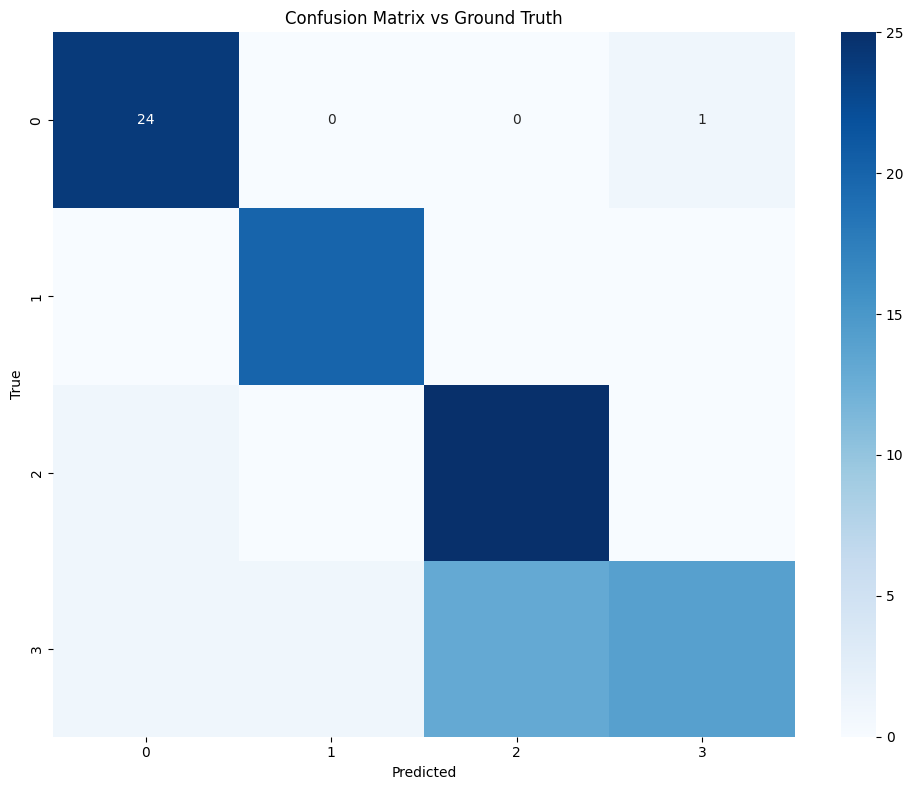

In [ ]:
if ground_truth:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    
    # Adicionar ground truth
    df_with_consensus['ground_truth'] = ground_truth
    
    # Accuracy
    accuracy = accuracy_score(
        df_with_consensus['ground_truth'],
        df_with_consensus['most_common_annotation']
    )
    
    logger.success(f"\n🎯 Accuracy: {accuracy:.2%}")
    
    # Classification report
    logger.info("\nClassification Report:")
    print(classification_report(
        df_with_consensus['ground_truth'],
        df_with_consensus['most_common_annotation']
    ))
    
    # Confusion matrix
    cm = confusion_matrix(
        df_with_consensus['ground_truth'],
        df_with_consensus['most_common_annotation']
    )
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix vs Ground Truth')
    plt.tight_layout()
    plt.savefig('./results/confusion_vs_ground_truth.png', dpi=150)
    plt.show()
    
else:
    logger.info("\n⚠️  Ground truth não disponível - pulando validação")

## 9️⃣ Exportar Resultados

In [ ]:
import json
from pathlib import Path

# Criar diretório
results_dir = Path('./results/final')
results_dir.mkdir(parents=True, exist_ok=True)

# Salvar CSVs
df_with_consensus.to_csv(results_dir / 'dataset_anotado_completo.csv', index=False)
logger.info(f"✓ Salvos: {len(df_with_consensus)} registros")

# Alta confiança
high_conf = df_with_consensus[df_with_consensus['consensus_score'] >= 0.8]
high_conf.to_csv(results_dir / 'alta_confianca.csv', index=False)
logger.info(f"✓ Alta confiança: {len(high_conf)} registros")

# Necessita revisão
low_conf = df_with_consensus[df_with_consensus['consensus_score'] < 0.8]
low_conf.to_csv(results_dir / 'necessita_revisao.csv', index=False)
logger.info(f"✓ Necessita revisão: {len(low_conf)} registros")

# Sumário JSON
summary = {
    'dataset': {
        'name': dataset_name,
        'total_texts': len(texts),
        'categories': categories,
        'has_ground_truth': ground_truth is not None
    },
    'config': {
        'models': DEFAULT_MODELS,
        'total_models': len(annotator.models),
        'use_alternative_params': annotator.use_alternative_params,
        'num_repetitions': num_repetitions,
        'total_annotations': len(texts) * len(annotator.models) * num_repetitions
    },
    'results': {
        'consensus_mean': float(df_with_consensus['consensus_score'].mean()),
        'consensus_median': float(df_with_consensus['consensus_score'].median()),
        'high_consensus': int((df_with_consensus['consensus_level'] == 'high').sum()),
        'medium_consensus': int((df_with_consensus['consensus_level'] == 'medium').sum()),
        'low_consensus': int((df_with_consensus['consensus_level'] == 'low').sum()),
    },
    'metrics': {
        'fleiss_kappa': float(report['fleiss_kappa']),
        'fleiss_interpretation': report['fleiss_interpretation']
    }
}

if ground_truth:
    summary['validation'] = {
        'accuracy': float(accuracy)
    }

with open(results_dir / 'sumario_experimento.json', 'w') as f:
    json.dump(summary, f, indent=2)

logger.success("\n✓ Resultados exportados com sucesso!")

16:34:43 | INFO     | ✓ Salvos: 100 registros
16:34:43 | INFO     | ✓ Alta confiança: 72 registros
16:34:43 | INFO     | ✓ Necessita revisão: 28 registros
16:34:43 | SUCCESS  | 
✓ Resultados exportados com sucesso!


## 🔟 Resumo Final

In [ ]:
logger.info("\n" + "="*80)
logger.success("RESUMO DO EXPERIMENTO")
logger.info("="*80)

logger.info(f"\n📊 Dataset: {dataset_name}")
logger.info(f"  Textos: {len(texts)}")
logger.info(f"  Categorias: {len(categories)}")

logger.info(f"\n🤖 Configuração:")
logger.info(f"  Modelos base: {len(DEFAULT_MODELS)}")
logger.info(f"  Total modelos: {len(annotator.models)}")
logger.info(f"  Alternative params: {annotator.use_alternative_params}")
logger.info(f"  Repetições: {num_repetitions}")

logger.info(f"\n📈 Consenso:")
logger.info(f"  Média: {df_with_consensus['consensus_score'].mean():.2%}")
logger.info(f"  Fleiss' Kappa: {report['fleiss_kappa']:.3f} ({report['fleiss_interpretation']})")

if ground_truth:
    logger.info(f"\n🎯 Validação:")
    logger.info(f"  Accuracy: {accuracy:.2%}")

logger.info(f"\n📁 Arquivos gerados em: {results_dir}/")

cache_stats = annotator.get_cache_stats()
logger.info(f"\n💾 Cache: {cache_stats['total_entries']} entradas")

logger.success("\n✅ Análise completa!")

16:34:43 | INFO     | 
16:34:43 | SUCCESS  | RESUMO DO EXPERIMENTO
16:34:43 | INFO     | ================================================================================
16:34:43 | INFO     | 
📊 Dataset: agnews
16:34:43 | INFO     |   Textos: 100
16:34:43 | INFO     |   Categorias: 4
16:34:43 | INFO     | 
🤖 Configuração:
16:34:43 | INFO     |   Modelos base: 5
16:34:43 | INFO     |   Total modelos: 5
16:34:43 | INFO     |   Alternative params: False
16:34:43 | INFO     |   Repetições: 1
16:34:43 | INFO     | 
📈 Consenso:
16:34:43 | INFO     |   Média: 81.60%
16:34:43 | INFO     |   Fleiss' Kappa: 0.569 (Moderado)
16:34:43 | INFO     | 
🎯 Validação:
16:34:43 | INFO     |   Accuracy: 83.00%
16:34:43 | INFO     | 
📁 Arquivos gerados em: results\final/
16:34:43 | INFO     | 
💾 Cache: 220 entradas
16:34:43 | SUCCESS  | 
✅ Análise completa!
